Multiclass classification with GPflow
--

*Alexander G. de G. Matthews and James Hensman, 2016*

In [1]:
from __future__ import print_function
import GPflow
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline

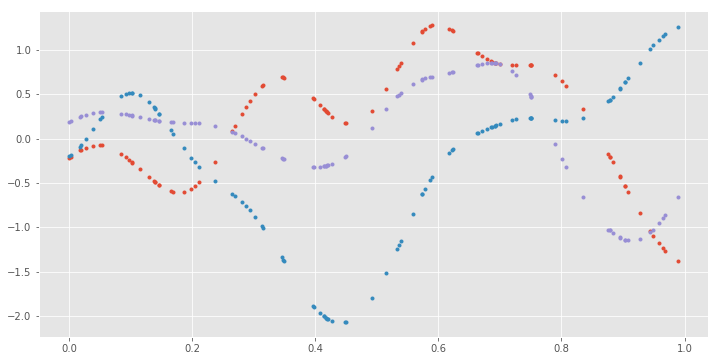

In [2]:
#make a one dimensional classification problem
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,3))

plt.figure(figsize=(12,6))
plt.plot(X, f, '.')

In [3]:
Y = np.argmax(f, 1).reshape(-1,1)

### Sparse Variational Gaussian approximation

In [4]:
lik = GPflow.likelihoods.MultiClass(3)
lik.invlink.epsilon.fixed = True
m = GPflow.svgp.SVGP(X, Y, 
                     kern=GPflow.kernels.Matern32(1) + GPflow.kernels.White(1, variance=0.01),
                     likelihood=lik,
                     Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)

In [5]:
m.kern.white.variance.fixed = True
m.Z.fixed = True
_ = m.optimize()

In [6]:
def plot(m):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = np.linspace(m.X.value.min(), m.X.value.max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    for i in range(m.likelihood.num_classes):
        x = m.X.value[m.Y.value.flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

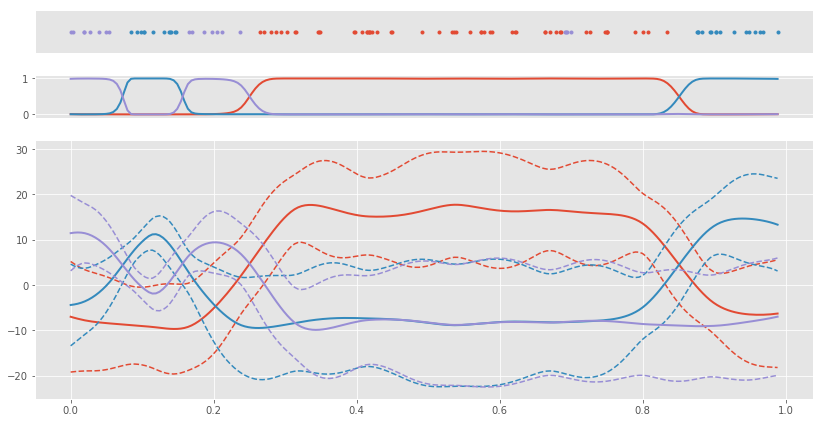

In [7]:
plot(m)

In [8]:
print(m.kern)

kern.matern32.lengthscales transform:+ve prior:None
[ 0.10404457]
kern.matern32.variance transform:+ve prior:None
[ 80.92236567]
kern.white.variance transform:+ve prior:None [FIXED]
[ 0.01]


### Sparse MCMC

In [9]:
lik = GPflow.likelihoods.MultiClass(3)
lik.invlink.epsilon.fixed = True
m = GPflow.sgpmc.SGPMC(X, Y, 
                     kern=GPflow.kernels.Matern32(1, lengthscales=0.1) + GPflow.kernels.White(1, variance=0.01),
                     likelihood=lik,
                     Z=X[::5].copy(), num_latent=3)

In [10]:
m.kern.matern32.variance.prior = GPflow.priors.Gamma(1.,1.)
m.kern.matern32.lengthscales.prior = GPflow.priors.Gamma(2.,2.)
m.kern.white.variance.fixed = True

In [11]:
_ = m.optimize(maxiter=10)

In [12]:
samples = m.sample(500, verbose=True, epsilon=0.04, Lmax=15)

Iteration:  100 	 Acc Rate:  71.0 %


Iteration:  200 	 Acc Rate:  84.0 %


Iteration:  300 	 Acc Rate:  55.0 %


Iteration:  400 	 Acc Rate:  70.0 %


Iteration:  500 	 Acc Rate:  71.0 %


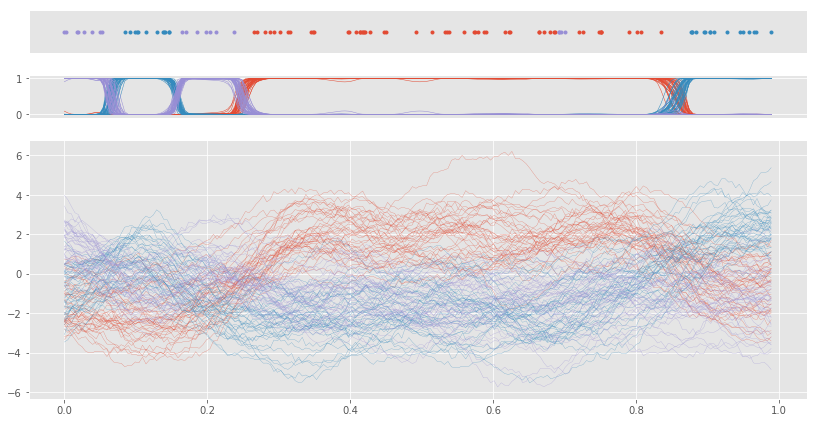

In [13]:
def plot_from_samples(m, samples):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = np.linspace(m.X.value.min(), m.X.value.max(), 200).reshape(-1,1)
    
    Fpred, Ypred = [], []
    for s in samples[100::10]: # burn 100, thin 10
        m.set_state(s)
        Ypred.append(m.predict_y(xx)[0])
        Fpred.append(m.predict_f_samples(xx, 1).squeeze())

    for i in range(m.likelihood.num_classes):
        x = m.X.value[m.Y.value.flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color = points.get_color()
        for F in Fpred:
            a1.plot(xx, F[:,i], color=color, lw=0.2, alpha=1.0)
        for Y in Ypred:
            a2.plot(xx, Y[:,i], color=color, lw=0.5, alpha=1.0)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])
        
    a3.set_xticks([])
    a3.set_yticks([])
    

plot_from_samples(m, samples)

In [14]:
df = m.get_samples_df(samples)

In [15]:
df.head()

,model.V,model.kern.matern32.lengthscales,model.kern.matern32.variance,model.kern.white.variance,model.likelihood.invlink.epsilon
0,"[[1.45964814085, -0.972108586687, -0.487539554...",[0.163728909507],[1.37484418378],[0.01],[0.001]
1,"[[1.45964814085, -0.972108586687, -0.487539554...",[0.163728909507],[1.37484418378],[0.01],[0.001]
2,"[[1.86426145374, -0.884570363616, -0.312259868...",[0.155335261541],[1.46083579577],[0.01],[0.001]
3,"[[1.86426145374, -0.884570363616, -0.312259868...",[0.155335261541],[1.46083579577],[0.01],[0.001]
4,"[[1.83101152731, -0.963497481675, -0.048693694...",[0.166821737082],[1.84100821378],[0.01],[0.001]


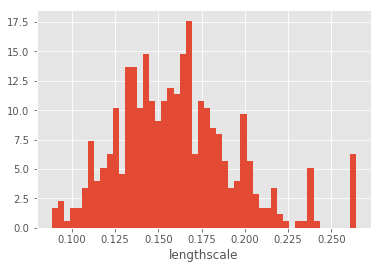

In [16]:
_ = plt.hist(np.vstack(df['model.kern.matern32.lengthscales']).flatten(), 50, normed=True)
plt.xlabel('lengthscale')